
# Análisis predictivo de FRR — KDF‑11 (Random Forest, validación y simulaciones)

Este cuaderno entrena **modelos de bosques aleatorios (Random Forest)** para predecir el **% de FRR por causa** (`faltante`, `extra`, `roto`, `posicion`) a partir de los parámetros de la KDF‑11, valida con **k-fold**, genera **importancias de variables** y permite **simulaciones** de tipo “¿qué pasa si cambio X y dejo todo lo demás igual?”.

**Archivo de entrada:** `FRR-11.xlsx`

> Autor: Francisco Tinoco + Copilot  
> Fecha de generación: 2025-12-05 17:19
    

In [ ]:
import os
import math
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Para modelado y validación
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import KFold, cross_validate
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print("Aviso: scikit-learn no está disponible. Instálalo con: !pip install scikit-learn")
    print("Error de importación:", e)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorios
DATA_PATH = Path('FRR-11.xlsx')
OUTPUT_DIR = Path('salidas_modelo')
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Directorio de salida: {OUTPUT_DIR.resolve()}")

Directorio de salida: C:\Users\jtinoco2\Downloads\Failures-PMI\salidas_modelo


In [5]:
import unicodedata
import re

def normalize_col(name: str) -> str:
    """Normaliza nombres de columnas: minúsculas, sin acentos, sin puntuación y espacios a guiones bajos."""
    if name is None:
        return ''
    s = str(name).strip().lower()
    # quita acentos
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    # reemplazos específicos frecuentes
    s = re.sub(r'[\\/]', '_', s)         # / y \ -> _
    s = s.replace('.', ' ').replace('#', 'num')
    s = s.replace('%', 'pct')
    # colapsa espacios a guion bajo
    s = '_'.join(s.split())
    return s

# Mapas de sinónimos -> objetivo canónico
COL_MAP = {
    'fecha': 'fecha',
    'num': 'num',
    'rv2': 'rv2',
    'rv4': 'rv4',
    'rv5': 'rv5',
    'rv6': 'rv6',
    'lim_max': 'lim_max',
    'lim_min': 'lim_min',
    'v3_kdf': 'v3_kdf',
    'v2_v3': 'v2_v3',
    'presion': 'presion',
    'angulo': 'angulo',
    'posision': 'posicion',   # manejo de typo frecuente
    'posicion': 'posicion',
    'vel': 'vel',
    'min': 'min',
    'min_': 'min',
    'faltante_frr': 'frr_faltante',
    'extra_frr': 'frr_extra',
    'roto_frr': 'frr_roto',
    'posicion_frr': 'frr_posicion',
    'total': 'frr_total'
}

# Candidatos de features y targets esperados (canónicos)
FEATURES_WISHLIST = ['rv2','rv4','rv5','rv6','lim_max','lim_min','v3_kdf','v2_v3','presion','angulo','posicion','vel','min']
TARGETS_WISHLIST = ['frr_faltante','frr_extra','frr_roto','frr_posicion']

# Leer Excel y detectar hoja con mejores columnas
xls = pd.ExcelFile(DATA_PATH, engine='openpyxl')
print('Hojas detectadas:', xls.sheet_names)

best_df = None
best_score = -1
best_sheet = None

for sheet in xls.sheet_names:
    df0 = pd.read_excel(xls, sheet_name=sheet)
    raw_cols = list(df0.columns)
    norm_cols = [normalize_col(c) for c in raw_cols]
    # aplica mapa de sinónimos
    mapped_cols = [COL_MAP.get(c, c) for c in norm_cols]
    df0.columns = mapped_cols
    # puntúa por cantidad de columnas esperadas presentes
    score = sum(1 for c in FEATURES_WISHLIST+TARGETS_WISHLIST+['frr_total'] if c in df0.columns)
    if score > best_score:
        best_score = score
        best_df = df0.copy()
        best_sheet = sheet

assert best_df is not None, "No se pudo cargar ninguna hoja con columnas esperadas. Revisa el archivo."
print(f"Se usará la hoja: {best_sheet} (score columnas={best_score})")

# Vista previa
try:
    display(best_df.head())
except Exception:
    print(best_df.head())
print("Columnas normalizadas:")
print(sorted(best_df.columns))

# Chequeo de consistencia: suma de causas vs total (si existe)
if set(TARGETS_WISHLIST).issubset(best_df.columns) and 'frr_total' in best_df.columns:
    suma_causas = best_df[['frr_faltante','frr_extra','frr_roto','frr_posicion']].sum(axis=1)
    dif = (best_df['frr_total'] - suma_causas)
    print('Resumen coherencia (Total ≈ suma de causas):')
    print('Dif media:', float(dif.mean()))
    print('Dif std  :', float(dif.std()))
    print('Dif min  :', float(dif.min()))
    print('Dif max  :', float(dif.max()))

Hojas detectadas: ['Sheet2']
Se usará la hoja: Sheet2 (score columnas=18)


,fecha,num,rv2,rv4,rv5,rv6,lim_max,lim_min,v3_kdf,v2_v3,...,falla_extra,falla_roto,falla_posicion,vel,min,frr_faltante,frr_extra,frr_roto,frr_posicion,frr_total
0,2025-12-04,1,0.21,0.210,0.1,2.0,170,50,0.949,1.51,...,0,11,39,2600,3,0.256410,0.000000,0.141026,0.500000,0.897436
1,2025-12-04,2,0.21,0.175,0.1,2.0,170,50,0.949,1.51,...,1,9,30,2600,3,0.294872,0.012821,0.115385,0.384615,0.807692
2,2025-12-04,3,0.21,0.175,0.1,2.0,170,50,0.941,1.51,...,2,9,12,2600,3,0.384615,0.025641,0.115385,0.153846,0.679487
3,2025-12-04,4,0.21,0.175,0.1,2.0,170,50,0.941,1.51,...,1,10,17,2600,3,0.269231,0.012821,0.128205,0.217949,0.628205
4,2025-12-04,5,0.21,0.210,0.1,2.0,170,50,0.941,1.51,...,0,11,13,2600,3,0.384615,0.000000,0.141026,0.166667,0.692308


Columnas normalizadas:
['angulo', 'falla_extra', 'falla_faltante', 'falla_posicion', 'falla_roto', 'fecha', 'frr_extra', 'frr_faltante', 'frr_posicion', 'frr_roto', 'frr_total', 'lim_max', 'lim_min', 'min', 'num', 'posicion', 'presion', 'rv2', 'rv4', 'rv5', 'rv6', 'v2_v3', 'v3_kdf', 'vel']
Resumen coherencia (Total ≈ suma de causas):
Dif media: 1.1102230246251566e-17
Dif std  : 1.0425568698138227e-16
Dif min  : -2.220446049250313e-16
Dif max  : 4.440892098500626e-16


### 3. Preparación de features (X) y objetivos (Y)

In [6]:
# Filtramos columnas disponibles
features = [c for c in FEATURES_WISHLIST if c in best_df.columns]
missing_feat = [c for c in FEATURES_WISHLIST if c not in features]

targets = [c for c in TARGETS_WISHLIST if c in best_df.columns]
missing_tgt = [c for c in TARGETS_WISHLIST if c not in targets]

print('Features usados (X):', features)
print('Targets usados (Y):', targets)
if missing_feat:
    print('Aviso: Faltan en el archivo estas features esperadas:', missing_feat)
if missing_tgt:
    print('Aviso: Faltan en el archivo estos targets esperados:', missing_tgt)

# Copiamos X e Y
X = best_df[features].copy()
Y = best_df[targets].copy()

# Casting numérico y manejo de NaN
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')
for c in Y.columns:
    Y[c] = pd.to_numeric(Y[c], errors='coerce')

# Eliminamos filas con NaN en X o Y (alternativa: imputación)
mask_ok = X.notna().all(axis=1) & Y.notna().all(axis=1)
X = X[mask_ok].reset_index(drop=True)
Y = Y[mask_ok].reset_index(drop=True)
print(f"Filas tras limpieza: {len(X)}")

# Guardamos dataset limpio (opcional)
X.join(Y).to_excel(OUTPUT_DIR / 'dataset_limpio.xlsx', index=False, engine='openpyxl')
print('Dataset limpio exportado a: salidas_modelo/dataset_limpio.xlsx')
    

Features usados (X): ['rv2', 'rv4', 'rv5', 'rv6', 'lim_max', 'lim_min', 'v3_kdf', 'v2_v3', 'presion', 'angulo', 'posicion', 'vel', 'min']
Targets usados (Y): ['frr_faltante', 'frr_extra', 'frr_roto', 'frr_posicion']
Filas tras limpieza: 45
Dataset limpio exportado a: salidas_modelo/dataset_limpio.xlsx


### 4. Entrenamiento con Random Forest por causa (k-fold cross-validation)

In [7]:
if not SKLEARN_OK:
    raise SystemExit('scikit-learn es requerido para continuar.')

k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

modelos: Dict[str, RandomForestRegressor] = {}
cv_resultados: Dict[str, dict] = {}

for target in targets:
    y = Y[target].values
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=10,
        min_samples_leaf=3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }

    scores = cross_validate(rf, X.values, y, cv=cv, scoring=scoring, return_train_score=False)

    res = {
        'MAE_mean': -scores['test_MAE'].mean(),
        'MAE_std' :  scores['test_MAE'].std(),
        'RMSE_mean': -scores['test_RMSE'].mean(),
        'RMSE_std' :  scores['test_RMSE'].std(),
        'R2_mean': scores['test_R2'].mean(),
        'R2_std' : scores['test_R2'].std(),
    }

    cv_resultados[target] = res

    # Entrenamos modelo final en todo el dataset
    rf.fit(X.values, y)
    modelos[target] = rf

# Mostrar resultados
print('Métricas k-fold (menor es mejor en MAE/RMSE):')
res_df = pd.DataFrame(cv_resultados).T
try:
    display(res_df)
except Exception:
    print(res_df)
res_df.to_excel(OUTPUT_DIR / 'metricas_cv.xlsx', engine='openpyxl')
print('Métricas exportadas a: salidas_modelo/metricas_cv.xlsx')

Métricas k-fold (menor es mejor en MAE/RMSE):


,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
frr_faltante,0.059600,0.013429,0.071588,0.017662,-0.143978,0.358107
frr_extra,0.023282,0.011857,0.030513,0.017895,-2.383047,4.481022
frr_roto,0.028651,0.004056,0.037361,0.010401,-0.112234,0.365700
frr_posicion,0.124948,0.037761,0.163842,0.040041,0.169355,0.515258


Métricas exportadas a: salidas_modelo/metricas_cv.xlsx


### 5. Importancia de variables (Gini) y Permutation Importance

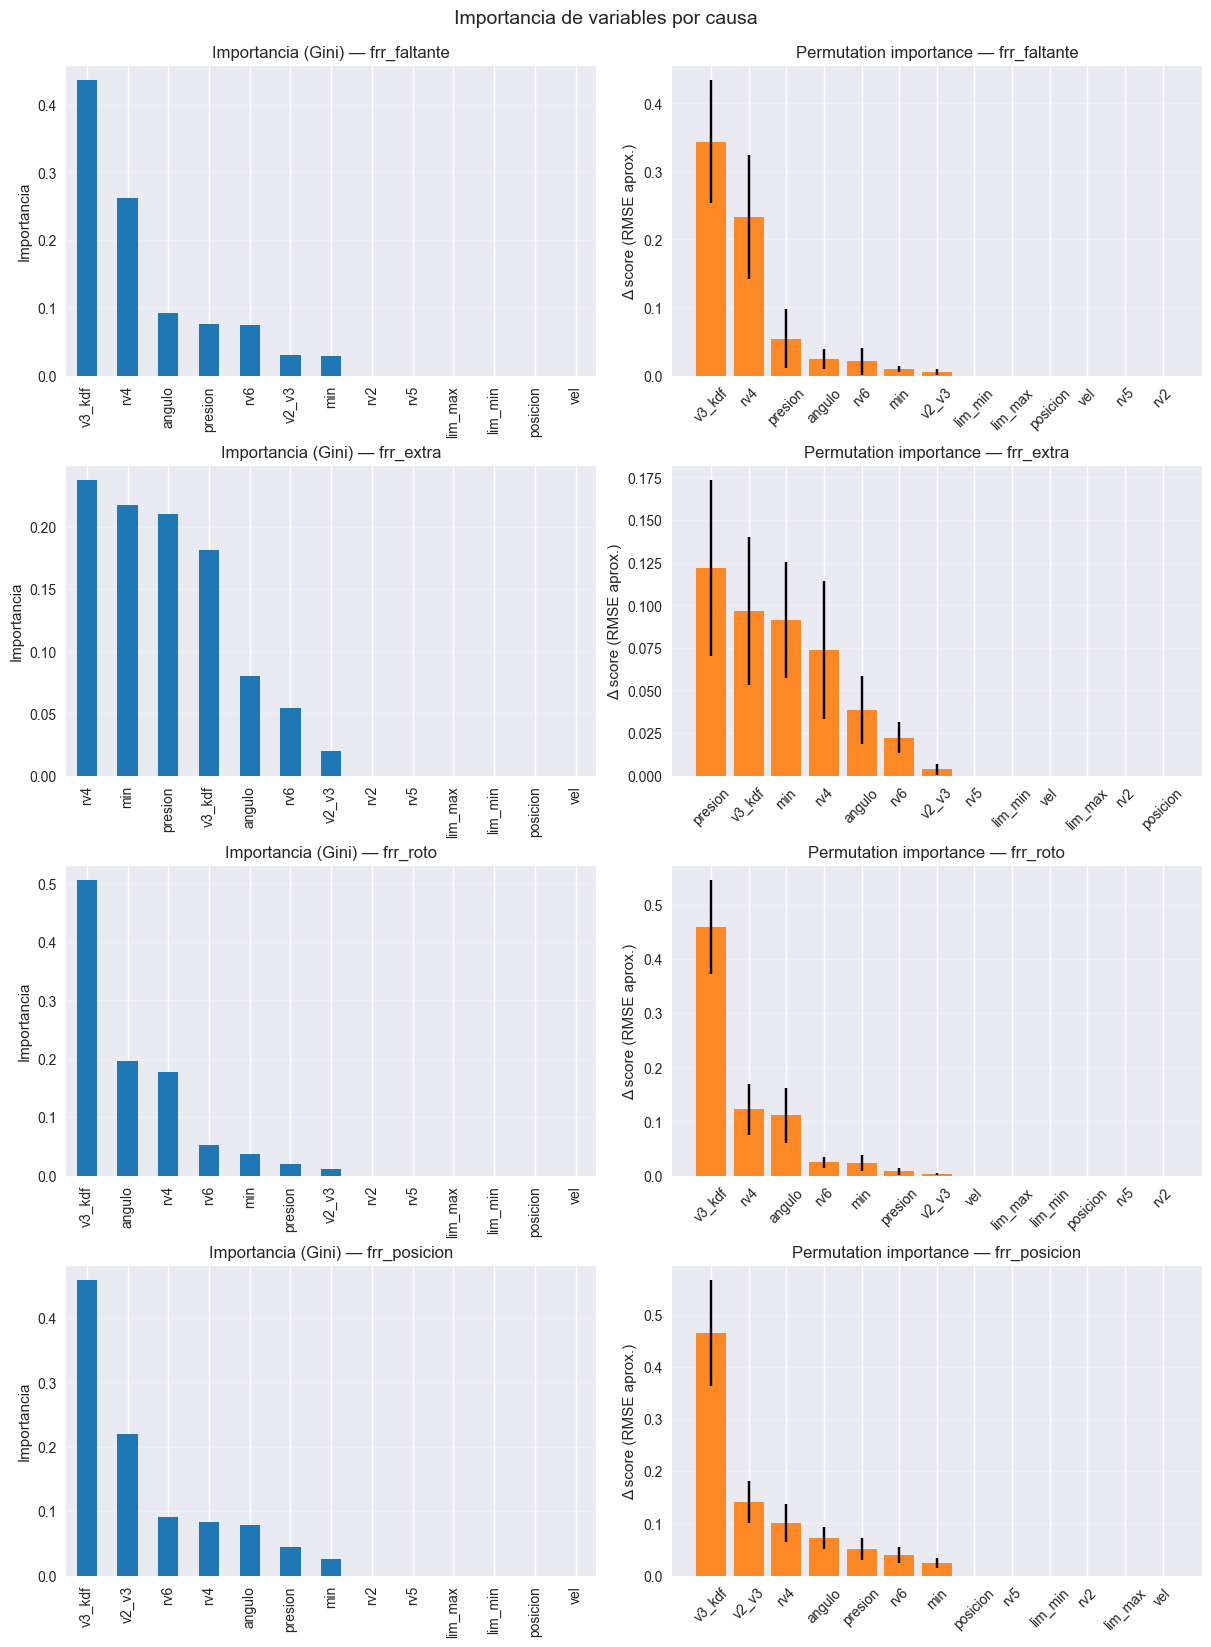

Gráfica guardada en: salidas_modelo/importancias_variables.png


In [8]:
fig, axes = plt.subplots(len(targets), 2, figsize=(12, 4*len(targets)), constrained_layout=True)
if len(targets) == 1:
    axes = np.array([axes])

for i, target in enumerate(targets):
    rf = modelos[target]
    # Importancia por impureza (Gini)
    imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
    imp.plot(kind='bar', ax=axes[i,0], color='#1f77b4')
    axes[i,0].set_title(f"Importancia (Gini) — {target}")
    axes[i,0].set_ylabel('Importancia')
    axes[i,0].grid(axis='y', alpha=0.3)

    # Permutation importance sobre el conjunto completo (aprox.)
    pi = permutation_importance(rf, X.values, Y[target].values, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
    pi_mean = pd.Series(pi.importances_mean, index=features).sort_values(ascending=False)
    pi_std  = pd.Series(pi.importances_std, index=features).loc[pi_mean.index]
    axes[i,1].bar(pi_mean.index, pi_mean.values, yerr=pi_std.values, color='#ff7f0e', alpha=0.9, capsize=3)
    axes[i,1].set_title(f"Permutation importance — {target}")
    axes[i,1].set_ylabel('Δ score (RMSE aprox.)')
    axes[i,1].tick_params(axis='x', rotation=45)
    axes[i,1].grid(axis='y', alpha=0.3)

plt.suptitle('Importancia de variables por causa', y=1.02, fontsize=14)
plt.savefig(OUTPUT_DIR / 'importancias_variables.png', dpi=150, bbox_inches='tight')
plt.show()
print('Gráfica guardada en: salidas_modelo/importancias_variables.png')
    

### 6. Simulaciones “¿qué pasa si…?” variando un parámetro

Fila de referencia (última observación):


,rv2,rv4,rv5,rv6,lim_max,lim_min,v3_kdf,v2_v3,presion,angulo,posicion,vel,min
44,0.21,0.225,0.1,2.0,170.0,50.0,0.952,1.507,3.4,8.5,190.0,2600.0,3.0


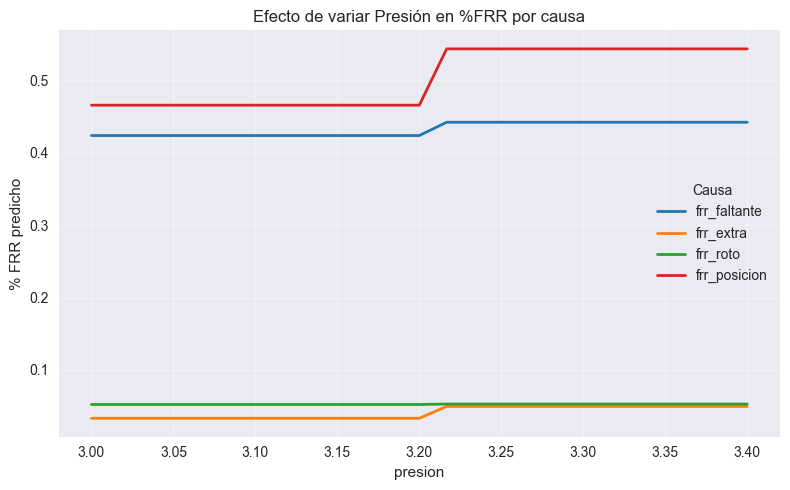

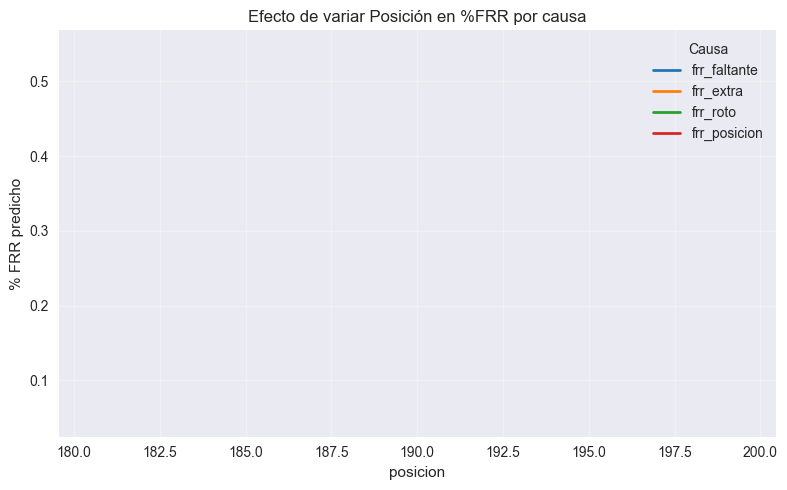

In [9]:
from dataclasses import dataclass

@dataclass
class SimulacionResultado:
    feature: str
    valores: np.ndarray
    preds: pd.DataFrame  # columnas = targets


def simular_parametro(fila_ref: pd.Series, feature: str, valores: np.ndarray) -> SimulacionResultado:
    """Simula variando una sola feature y predice FRR por causa con los modelos entrenados."""
    if feature not in X.columns:
        raise ValueError(f"La feature '{feature}' no está en X. Features disponibles: {list(X.columns)}")

    base = fila_ref.copy()
    grid = []
    for v in valores:
        row = base.copy()
        row[feature] = v
        grid.append(row.values)

    grid = np.array(grid)
    pred_dict = {}
    for target in targets:
        pred = modelos[target].predict(grid)
        pred = np.clip(pred, 0, 100)  # límites lógicos 0-100
        pred_dict[target] = pred

    preds_df = pd.DataFrame(pred_dict)
    return SimulacionResultado(feature=feature, valores=valores, preds=preds_df)


def graficar_simulacion(sim_res: SimulacionResultado, titulo: str = None):
    plt.figure(figsize=(8,5))
    for col, color in zip(sim_res.preds.columns, ['#1f77b4','#ff7f0e','#2ca02c','#d62728']):
        plt.plot(sim_res.valores, sim_res.preds[col], label=col, linewidth=2, color=color)
    plt.xlabel(sim_res.feature)
    plt.ylabel('% FRR predicho')
    plt.grid(alpha=0.3)
    plt.legend(title='Causa')
    if not titulo:
        titulo = f"Simulación variando '{sim_res.feature}'"
    plt.title(titulo)
    plt.tight_layout()

# Elegimos una fila de referencia (la última por defecto)
ref = X.iloc[-1]
print('Fila de referencia (última observación):')
try:
    display(ref.to_frame().T)
except Exception:
    print(ref.to_frame().T)

# Ejemplo 1: variar Presión
if 'presion' in X.columns:
    a = X['presion'].min()
    b = X['presion'].max()
    vals_pres = np.linspace(a, b, 25)
    sim1 = simular_parametro(ref, 'presion', vals_pres)
    graficar_simulacion(sim1, 'Efecto de variar Presión en %FRR por causa')
    plt.savefig(OUTPUT_DIR / 'sim_presion.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Columna 'presion' no disponible; omitiendo simulación de presión.")

# Ejemplo 2: variar Posición (si existe)
if 'posicion' in X.columns:
    a = X['posicion'].quantile(0.05)
    b = X['posicion'].quantile(0.95)
    vals_pos = np.linspace(a, b, 25)
    sim2 = simular_parametro(ref, 'posicion', vals_pos)
    graficar_simulacion(sim2, 'Efecto de variar Posición en %FRR por causa')
    plt.savefig(OUTPUT_DIR / 'sim_posicion.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Columna 'posicion' no disponible; omitiendo simulación de posición.")
    

### 7. Predicción sobre todo el dataset y chequeo de coherencia

In [10]:
preds_all = pd.DataFrame(index=X.index)
for target in targets:
    preds_all[target] = np.clip(modelos[target].predict(X.values), 0, 100)

# Suma de causas como Total estimado
preds_all['frr_total_estimado'] = preds_all.sum(axis=1)

# Unimos con datos originales (si existe frr_total real)
resultado = best_df.copy()
for c in preds_all.columns:
    resultado[f'pred_{c}'] = preds_all[c]

# Si existe frr_total real, comparamos
if 'frr_total' in resultado.columns:
    resultado['dif_total'] = resultado['pred_frr_total_estimado'] - resultado['frr_total']

resultado.to_excel(OUTPUT_DIR / 'predicciones_dataset.xlsx', index=False, engine='openpyxl')
print('Predicciones exportadas a: salidas_modelo/predicciones_dataset.xlsx')

# Vista rápida
cols_pred = [c for c in resultado.columns if c.startswith('pred_')]
try:
    display(resultado[cols_pred].head())
except Exception:
    print(resultado[cols_pred].head())
    

Predicciones exportadas a: salidas_modelo/predicciones_dataset.xlsx


,pred_frr_faltante,pred_frr_extra,pred_frr_roto,pred_frr_posicion,pred_frr_total_estimado
0,0.343176,0.012012,0.112227,0.336718,0.804133
1,0.323223,0.015293,0.115689,0.305373,0.759578
2,0.324284,0.015402,0.118332,0.172612,0.630630
3,0.324284,0.015402,0.118332,0.172612,0.630630
4,0.336336,0.010661,0.116134,0.175661,0.638792


In [ ]:
### 8. Guardar modelos entrenados 

import pickle
for target, model in modelos.items():
    path = OUTPUT_DIR / f"rf_{target}.pkl"
    with open(path, 'wb') as f:
        pickle.dump(model, f)
print('Modelos guardados en carpeta salidas_modelo/*.pkl')
    


## 9. Notas finales y próximos pasos

- Este cuaderno entrena **Random Forest por causa** con validación k-fold y reporta **MAE / RMSE / R²**.  
- Las **importancias** (Gini y permutación) ayudan a priorizar parámetros.  
- Las **simulaciones** permiten ver el efecto de mover **un** parámetro manteniendo los demás fijos.

**Mejoras posibles:**
1. Probar **XGBoost/LightGBM** (si están disponibles) y comparar contra RF en k-fold.  
2. Añadir **bandas de predicción** (conformal prediction o cuantiles) para cuantificar incertidumbre con pocos datos.  
3. Introducir **interacciones**: simulaciones 2D (barrer `presion` y `angulo` juntos) para mapas de calor.  
4. Postproceso de **coherencia**: si se requiere, reescalar la suma de causas para que no exceda un `Total` objetivo.

> Si deseas, puedo adaptar este cuaderno a tu **app de Streamlit** para subir un Excel semanal y devolver métricas, gráficas y simulaciones con un solo clic.
    